In [1]:
!pip install kaggle

In [2]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("GPU : {}".format(tf.test.gpu_device_name()))
else:
    print("NO")

GPU : /device:GPU:0


## Load data
You can use the API from kaggle or download the data set from kaggle

https://www.kaggle.com/datasets/sovitrath/cub-200-bird-species-xml-detection-dataset/code?datasetId=2795899


In [3]:
from google.colab import files

# upload kaggle.json
uploaded = files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sovitrath/cub-200-bird-species-xml-detection-dataset


Saving kaggle.json to kaggle (1).json
cub-200-bird-species-xml-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# 解壓縮
import zipfile
with zipfile.ZipFile('cub-200-bird-species-xml-detection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("cub-200-bird-species-xml-detection-dataset")

In [5]:
#for colab
trainImg_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_images'
trainLabel_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_labels'
validImg_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_images'
validLabel_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_labels'

#for kaggle
# trainImg_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_images'
# trainLabel_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_labels'
# validImg_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_images'
# validLabel_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_labels'

##Choosing Model

Choose an object detection model suitable for detecting birds, such as YOLO, SSD, Faster R-CNN, etc. You can choose to use a pre-trained model or train a new model, depending on your dataset and task requirements.

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate
# 選用SSD
def create_ssd_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 凍結基礎模型層
    for layer in base_model.layers:
        layer.trainable = False

    # 新層預測邊框
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(4)(x)  #(xmin, ymin, xmax, ymax)

    model = Model(inputs=base_model.input, outputs=x)
    return model

ssd_model = create_ssd_model()

ssd_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

## Preprocessing and Training (optional) (1%)

Read the downloaded image data using an appropriate image processing library (e.g. OpenCV, PIL). Next, the XML annotation file is parsed to obtain the location and category information of the bird objects in each image. The images are then scaled and normalized according to the needs of the model, ensuring that the dimensions and numerical range of the input image match the model's expectations. Finally, the data set is divided into a training set and a validation set to evaluate the model performance when training the model.

If you choose to train the model, please choose an appropriate loss function (such as mean square error), an optimizer (such as Adam or SGD), and the corresponding training parameters, such as learning rate and batch size. Model training is done using the training set, either transfer learning (initialized with pre-trained model weights) or training from scratch. Finally, the performance of the model is evaluated using the validation set to ensure its generalization ability.

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

def resize_box(box, orig_size, target_size):
    x_scale = target_size[0] / orig_size[0]
    y_scale = target_size[1] / orig_size[1]

    resized_box = [
        int(box[0] * x_scale),
        int(box[1] * y_scale),
        int(box[2] * x_scale),
        int(box[3] * y_scale)
    ]
    return resized_box

class BirdDataset(Sequence):
    def __init__(self, image_folder, label_folder, batch_size, img_size=(224, 224)):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []

        for file_name in batch_x:
            img_path = os.path.join(self.image_folder, file_name)  # 圖像的路徑
            image = self.load_image(img_path)  # 處理圖像
            images.append(image)

            label_path = os.path.join(self.label_folder, file_name.replace('.jpg', '.xml'))
            label = self.parse_xml(label_path)
            labels.append(label)

        return np.array(images), np.array(labels)

    def load_image(self, path):
        image = cv2.imread(path)
        image = cv2.resize(image, self.img_size)
        image = image / 255.0  # Normalize to [0, 1]
        return image

    def parse_xml(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # 原尺寸
        for size in root.findall('size'):
            orig_width = int(size.find('width').text)
            orig_height = int(size.find('height').text)

        orig_size = (orig_width, orig_height)
        target_size = self.img_size

        # 假設圖中只有一物件
        member = root.find('object')
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        box = [xmin, ymin, xmax, ymax]
        resized_box = resize_box(box, orig_size, target_size)

        return resized_box



In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy

import tensorflow as tf

def compute_iou(y_true, y_pred):
    """
    計算IoU
    y_true和y_pred的均為(batch_size, 4)，其中4個值為(xmin, ymin, xmax, ymax)
    """
    # 確保為浮點數
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 分解預測和真實值
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = tf.split(y_pred, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = tf.split(y_true, 4, axis=1)

    # 計算交集的坐標
    xmin_intersect = tf.maximum(xmin_pred, xmin_true)
    ymin_intersect = tf.maximum(ymin_pred, ymin_true)
    xmax_intersect = tf.minimum(xmax_pred, xmax_true)
    ymax_intersect = tf.minimum(ymax_pred, ymax_true)

    # 計算交集的面積
    intersect_area = tf.maximum(xmax_intersect - xmin_intersect, 0) * tf.maximum(ymax_intersect - ymin_intersect, 0)

    # 計算預測和真實邊界框的面積
    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    # 計算聯集的面積
    union_area = pred_area + true_area - intersect_area

    # 計算IoU
    iou = intersect_area / (union_area + tf.keras.backend.epsilon())

    return iou


def iou_loss(y_true, y_pred):
    return 1 - compute_iou(y_true, y_pred)


# 設定學習率
#learning_rate = 0.001
initial_learning_rate = 0.002
decay_steps = 188
decay_rate = 0.9
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 回調
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=3,
    min_lr=0.0001,
    verbose=1)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

adam_optimizer = Adam(learning_rate=lr_schedule)


# 使用Adam優化器，並設定學習率
#adam_optimizer = Adam(learning_rate=learning_rate)


# 數據生成器
batch_size = 32  # 根據記憶體限制
train_dataset = BirdDataset(trainImg_folder, trainLabel_folder, batch_size)
valid_dataset = BirdDataset(validImg_folder, validLabel_folder, batch_size)


# 訓練模型
ssd_model.compile(optimizer='adam', loss='mean_squared_error')
epochs = 10
ssd_model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)

# 再用IoU訓練
ssd_model.compile(optimizer=adam_optimizer, loss=iou_loss)
epochs = 40
ssd_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=[lr_reducer])


Epoch 1/10
188/188 [==============================] - 80s 400ms/step - loss: 11074.5488 - val_loss: 6398.5825
Epoch 2/10
188/188 [==============================] - 70s 374ms/step - loss: 4252.8662 - val_loss: 2752.8481
Epoch 3/10
188/188 [==============================] - 71s 380ms/step - loss: 2181.0540 - val_loss: 1798.0396
Epoch 4/10
188/188 [==============================] - 70s 371ms/step - loss: 1679.9321 - val_loss: 1576.6042
Epoch 5/10
188/188 [==============================] - 67s 359ms/step - loss: 1535.5980 - val_loss: 1474.1968
Epoch 6/10
188/188 [==============================] - 68s 364ms/step - loss: 1444.1501 - val_loss: 1389.2745
Epoch 7/10
188/188 [==============================] - 69s 367ms/step - loss: 1363.4554 - val_loss: 1312.6720
Epoch 8/10
188/188 [==============================] - 69s 365ms/step - loss: 1289.1395 - val_loss: 1242.3403
Epoch 9/10
188/188 [==============================] - 69s 370ms/step - loss: 1222.5844 - val_loss: 1180.8792
Epoch 10/10
188/18

In [9]:
for images, labels in valid_dataset:
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Images shape: (32, 224, 224, 3)
Labels shape: (32, 4)


## Evaluate Model Performance (1%)

Use the trained model to detect objects on the validation set, and calculate evaluation indicators such as average precision (AP) to evaluate the performance of the model. This helps confirm the model's accuracy and generalization ability on new data


In [10]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def iou(box1, box2):
    # 計算交集區域
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # 計算各自區域
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # 計算並集區域
    union_area = box1_area + box2_area - intersection_area

    # 計算交並比
    return intersection_area / union_area if union_area != 0 else 0


batch_images, batch_labels = next(iter(valid_dataset))
# 進行預測
predictions = ssd_model.predict(batch_images)
iou_scores = [iou(pred, true) for pred, true in zip(predictions, batch_labels)]

# IoU
iou_scores = np.array(iou_scores)

average_iou = np.mean(iou_scores)
print('average_iou:', average_iou)


# 評估模型
performance = ssd_model.evaluate(valid_dataset)
print("模型性能:", performance)

1/1 [==============================] - 1s 816ms/step
average_iou: 0.5648367477782674
182/182 [==============================] - 35s 193ms/step - loss: 0.4677
模型性能: 0.4677032232284546


## Inference and Visualization (3%)
For 5 test images, the trained model is used for inference, showing the predicted bounding boxes and comparing with the actual annotated ground truth. This helps visualize how the model performs in real-world situations and ensures it correctly detects and localizes avian objects.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, prediction, ground_truth):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # 預測邊界框
    rect = patches.Rectangle((prediction[0], prediction[1]), prediction[2] - prediction[0], prediction[3] - prediction[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # 實際框
    if ground_truth.ndim == 2:
        for truth in ground_truth:
            rect = patches.Rectangle((truth[0], truth[1]), truth[2] - truth[0], truth[3] - truth[1], linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    elif ground_truth.ndim == 1:
        rect = patches.Rectangle((ground_truth[0], ground_truth[1]), ground_truth[2] - ground_truth[0], ground_truth[3] - ground_truth[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    plt.show()


1/1 [==============================] - 0s 34ms/step


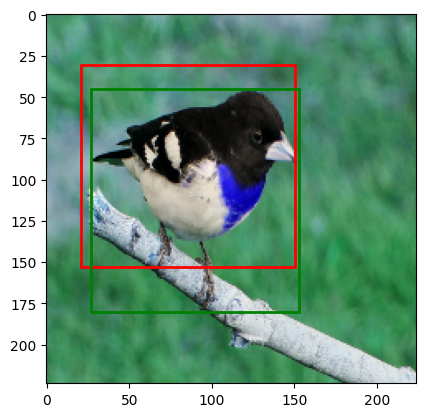

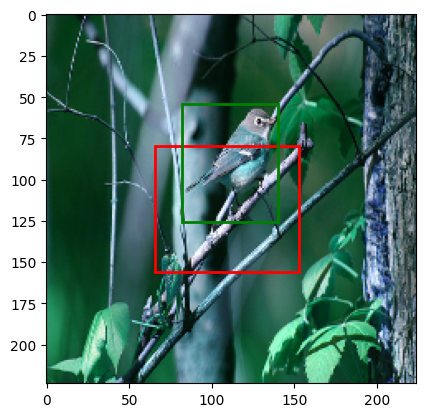

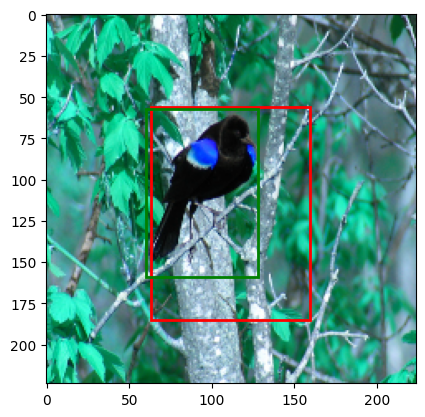

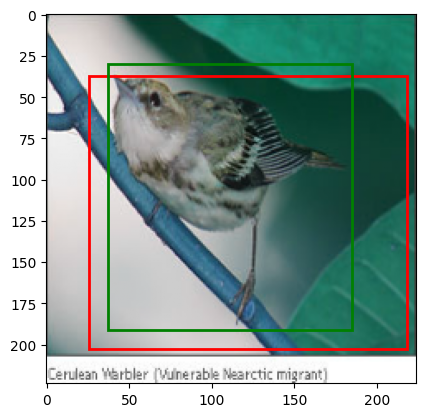

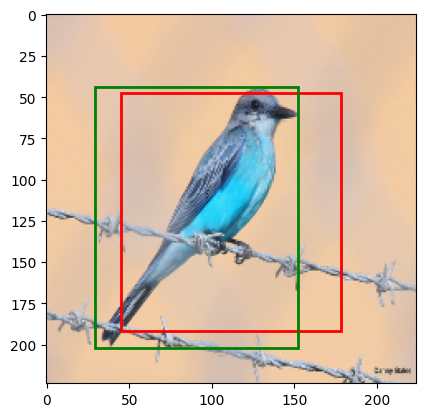

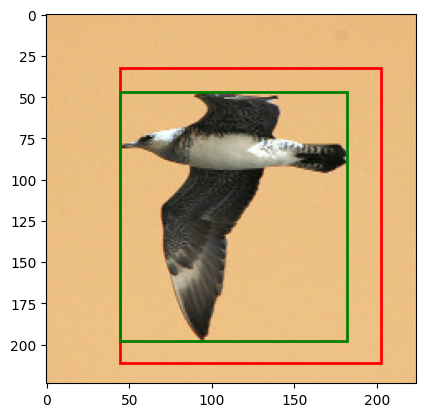

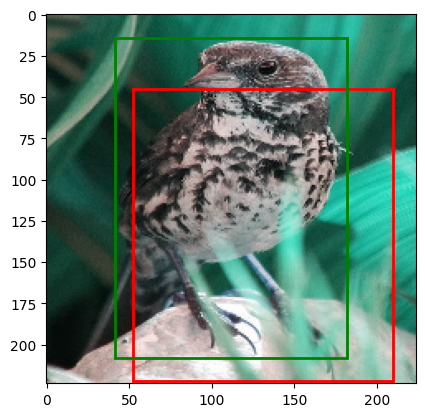

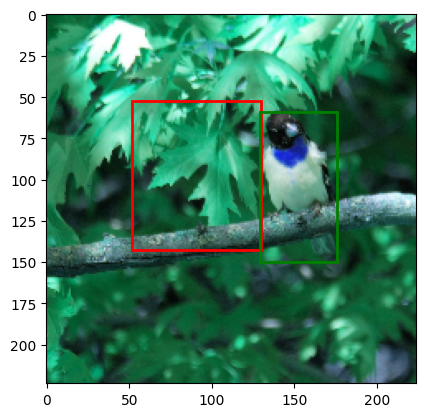

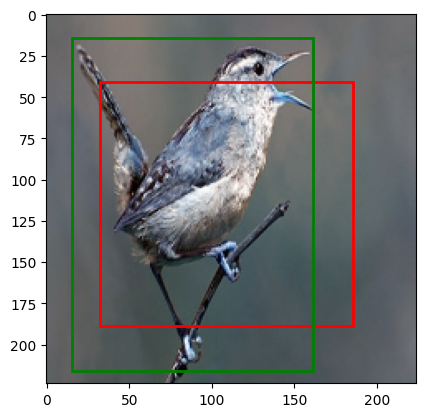

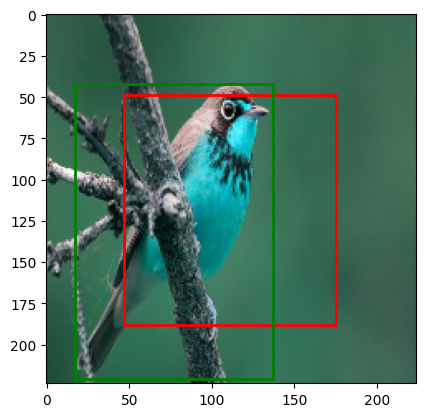

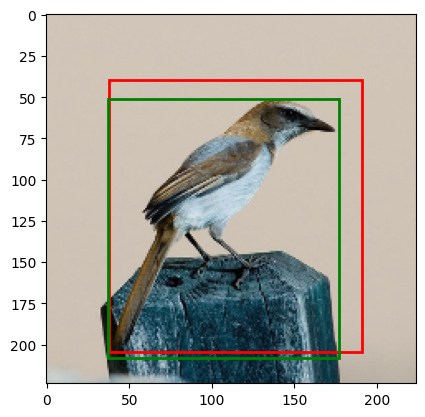

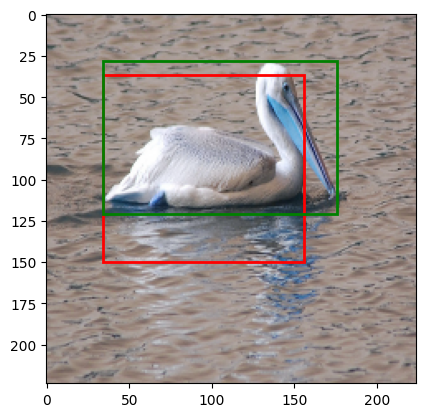

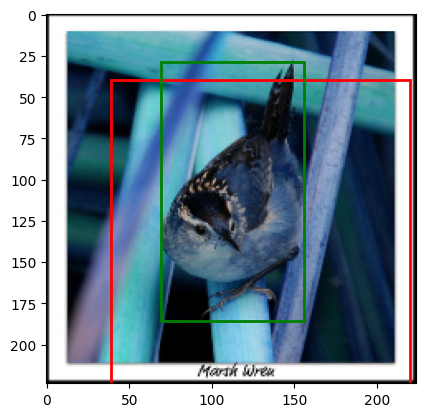

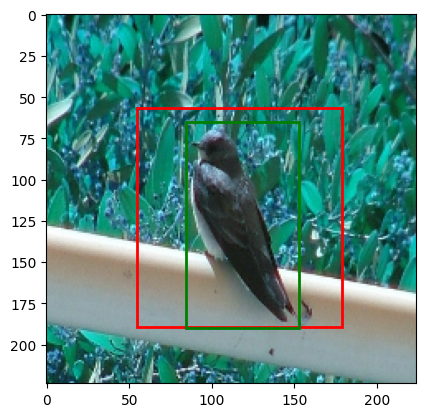

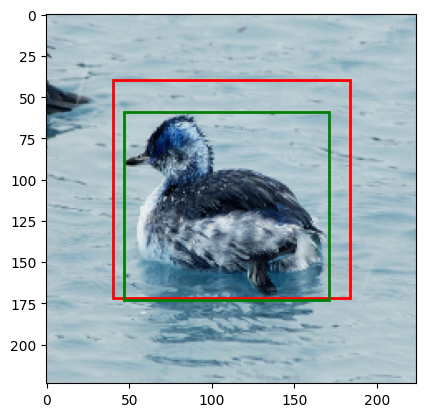

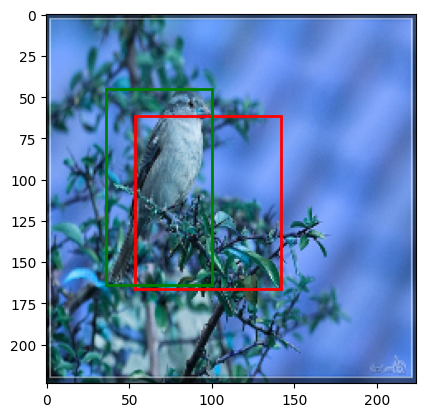

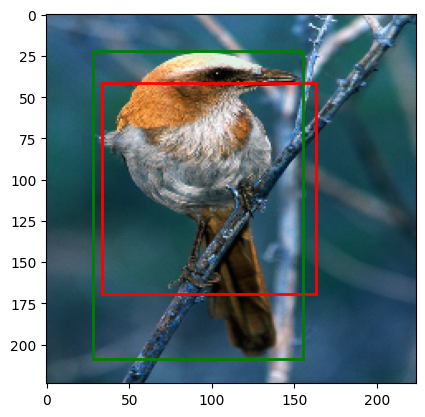

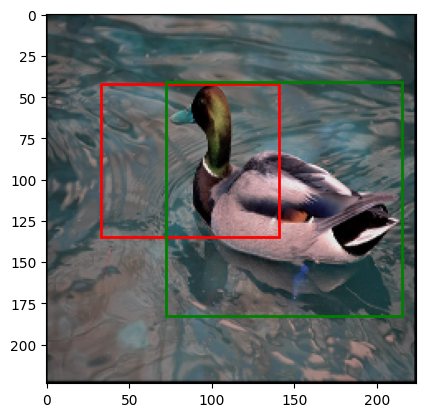

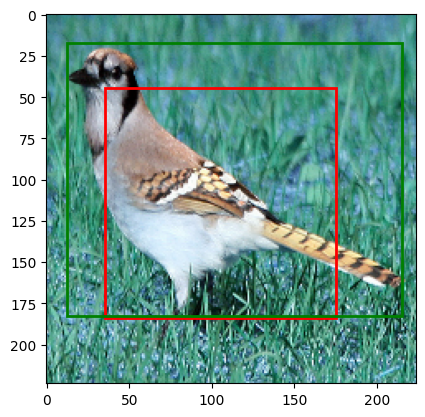

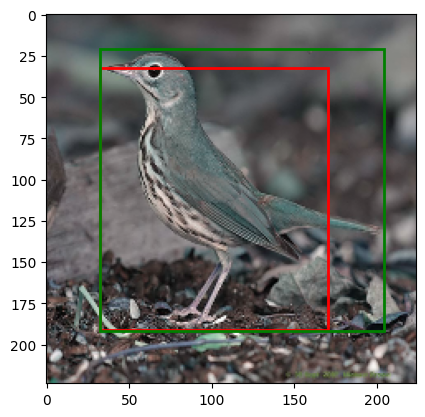

In [12]:
num_images_to_visualize = 20
count = 0

for batch_images, batch_labels in valid_dataset:
    predictions = ssd_model.predict(batch_images)

    for i in range(len(batch_images)):
        visualize_predictions(batch_images[i], predictions[i], batch_labels[i])
        count += 1

        if count >= num_images_to_visualize:
            break

    if count >= num_images_to_visualize:
        break
